#### Imports ####

In [ ]:
import os
import torch
import numpy as np
import normflows as nf
import hydra
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import kendalltau

from flows import RealNVP, NeuralSplineFlow
from prefflow import PrefFlow
from plotter import Plotter
from target import set_up_problem
from misc import convert_to_ranking
from pcbo_dataset import PCBO_SyntheticDataset
from torch.utils.data import DataLoader
from dag_visual import plot_dag
from parent_posterior import ParentPosterior
from acquisition import pig_pairwise

#### Load config file to set-up experiment and algorithm details ####

In [217]:
with hydra.initialize(version_base=None, config_path="conf"):
   os.chdir(os.getcwd())
   output_folder = os.path.join(os.getcwd(), 'temporary_outputs')
   cfg = hydra.compose(config_name="config.yaml",overrides=["+db=mysql"])
if not cfg.plot.showduringtraining: # Show plots?
    matplotlib.use('Agg') 

#### Device and Precision ####

In [218]:
torch.set_default_dtype(torch.float64 if cfg.device.precision_double else torch.float32)
device = torch.device(cfg.device.device)

#### Random seeds ####

In [219]:
import random
torch.manual_seed(cfg.exp.seed)
np.random.seed(cfg.exp.seed)
random.seed(cfg.exp.seed)

### Data Generation

In [ ]:
D = cfg.exp.d  # Dimension of the input space
ranking = cfg.data.k > 2  # Is it a ranking problem?
dataset = PCBO_SyntheticDataset(n_queries=cfg.data.n, k=cfg.data.k, d=D)
dataloader = DataLoader(dataset, batch_size=cfg.params.batch_size, shuffle=True)

Ranking problem: True


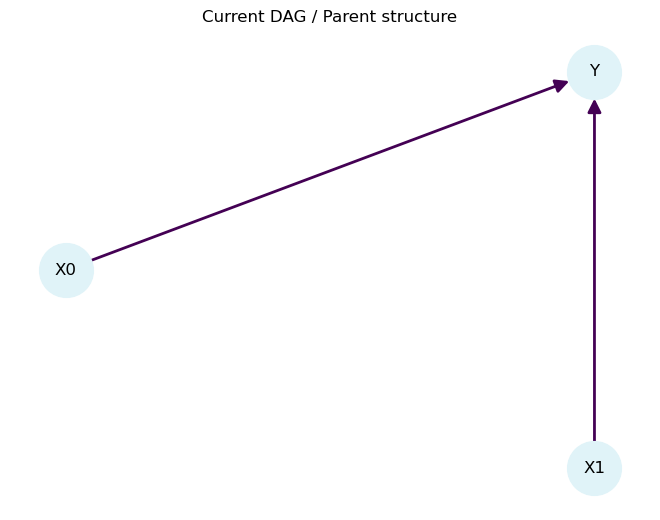

In [222]:
plot_dag(dataset.adj.numpy(), dataset.node_names)

#### Base distribution and Flow architecture ####

In [223]:
q0 = nf.distributions.DiagGaussian(D, trainable=False)
nflows = cfg.params.nflows
if cfg.params.flow == "realnvp":
    nfm = RealNVP(nflows,D,q0,device,cfg.device.precision_double)
if cfg.params.flow == "neuralsplineflow":
    nfm = NeuralSplineFlow(nflows,D,q0,device,cfg.device.precision_double)

In [ ]:
def minibatch(dataloader, ranking):
    x_choices, winner_indices = next(iter(dataloader))  # (B, k, d), (B,)
    x_choices = x_choices.permute(1,2,0)  # (k, d, B)

    if ranking:
        # pass only tensor of alternatives
        return x_choices  # shape (k, d, B)
    else:
        # pairwise expects a tuple (X_raw, Y)
        return x_choices, winner_indices

  #### Initialize preferential flow ####

In [225]:
prefflow = PrefFlow(nfm,D=D,s=cfg.modelparams.s,ranking=ranking,device=device,precision_double=cfg.device.precision_double)

#### Initialize optimizer ####

In [226]:
loss_hist = np.array([])
batch_size = cfg.params.batch_size
optimizer = getattr(torch.optim, cfg.params.optimizer.capitalize())
optimizer_prefflow = optimizer([{'params':prefflow.parameters()}],lr=cfg.params.lr, weight_decay=cfg.params.weight_decay)

### Parent Posterior

In [228]:
ppost = ParentPosterior(d=D, sigma_eps=0.1, sigma_theta=1.0, prior_sparsity=0.3)

causal_update_every = 50    # how often to normalise & log edge probabilities

### SGD FS-MAP + Causal Update Loop

In [230]:
for it in tqdm(range(cfg.params.max_iter), disable=not cfg.plot.progressbar_show):
    
    # Sample minibatch
    batch = minibatch(dataloader, ranking)  
    if	ranking:  # Ranking case
        X_raw = batch
        x_win = X_raw[0, :, 0]  # Winner of first sample (first alternative)
    else:  # Pairwise case
        X_raw, winner_idx = batch 
        win_first = (winner_idx[0].item() == 1)  # Look at first sample
        if win_first:  # If winner is first alternative
            x_win = X_raw[0, :, 0]
        else:
            x_win = X_raw[1, :, 0]

    # PNF Step
    prefflow.train()
    optimizer_prefflow.zero_grad()
    loss = -prefflow.logposterior(batch, cfg.modelparams.weightprior)
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer_prefflow.step()
    loss_hist = np.append(loss_hist, loss.item())

    # Causal Update
    with torch.no_grad():
        y_win_val = dataset.scm(x_win.unsqueeze(0))[0].item()  # scalar
    ppost.add_datapoint(x_win.unsqueeze(0), y_win_val)

    if (it + 1) % causal_update_every == 0:
        ppost.update_posterior()
        edge_probs = ppost.edge_posterior()
        print(f"[{it+1}] loss={loss.item():.3f}   edge P: {edge_probs.numpy()}")

    # (optional) plot every N iters
    # if (it+1) % cfg.plot.show_iter == 0:
    #     adj = np.array([[0,0,1],[0,0,1],[0,0,0]])
    #     edge_mat = np.array([[0,0,edge_probs[0]],
    #                          [0,0,edge_probs[1]],
    #                          [0,0,0]])
    #     plot_dag(adj, names=["X1","X2","Y"], edge_probs=edge_mat)

  3%|▎         | 56/2000 [00:01<00:54, 35.68it/s]

[50] loss=27.113   edge P: [1. 1.]


  5%|▌         | 104/2000 [00:03<00:50, 37.36it/s]

[100] loss=28.745   edge P: [1. 1.]


  8%|▊         | 156/2000 [00:04<00:48, 37.86it/s]

[150] loss=32.725   edge P: [1. 1.]


 10%|█         | 204/2000 [00:05<00:47, 37.91it/s]

[200] loss=30.430   edge P: [1. 1.]


 13%|█▎        | 256/2000 [00:07<00:49, 35.28it/s]

[250] loss=32.526   edge P: [1. 1.]


 15%|█▌        | 304/2000 [00:08<00:46, 36.32it/s]

[300] loss=31.238   edge P: [1. 1.]


 18%|█▊        | 356/2000 [00:09<00:44, 36.85it/s]

[350] loss=27.894   edge P: [1. 1.]


 20%|██        | 404/2000 [00:11<00:42, 37.61it/s]

[400] loss=29.996   edge P: [1. 1.]


 23%|██▎       | 456/2000 [00:12<00:41, 37.28it/s]

[450] loss=29.593   edge P: [1. 1.]


 25%|██▌       | 504/2000 [00:13<00:40, 37.08it/s]

[500] loss=25.926   edge P: [1. 1.]


 28%|██▊       | 556/2000 [00:15<00:40, 36.08it/s]

[550] loss=26.673   edge P: [1. 1.]


 30%|███       | 604/2000 [00:16<00:38, 36.12it/s]

[600] loss=29.289   edge P: [1. 1.]


 33%|███▎      | 656/2000 [00:18<00:36, 36.79it/s]

[650] loss=30.399   edge P: [1. 1.]


 35%|███▌      | 704/2000 [00:19<00:35, 36.43it/s]

[700] loss=27.485   edge P: [1. 1.]


 38%|███▊      | 756/2000 [00:21<00:32, 37.81it/s]

[750] loss=26.442   edge P: [1. 1.]


 40%|████      | 804/2000 [00:22<00:32, 37.08it/s]

[800] loss=27.585   edge P: [1. 1.]


 43%|████▎     | 856/2000 [00:23<00:30, 38.13it/s]

[850] loss=32.953   edge P: [1. 1.]


 45%|████▌     | 904/2000 [00:25<00:29, 36.71it/s]

[900] loss=29.374   edge P: [1. 1.]


 48%|████▊     | 956/2000 [00:26<00:28, 36.89it/s]

[950] loss=29.860   edge P: [1. 1.]


 50%|█████     | 1005/2000 [00:27<00:25, 38.69it/s]

[1000] loss=29.800   edge P: [1. 1.]


 53%|█████▎    | 1057/2000 [00:29<00:24, 38.04it/s]

[1050] loss=27.025   edge P: [1. 1.]


 55%|█████▌    | 1105/2000 [00:30<00:23, 37.51it/s]

[1100] loss=28.716   edge P: [1. 1.]


 58%|█████▊    | 1157/2000 [00:31<00:23, 36.33it/s]

[1150] loss=30.073   edge P: [1. 1.]


 60%|██████    | 1205/2000 [00:33<00:22, 35.74it/s]

[1200] loss=28.565   edge P: [1. 1.]


 63%|██████▎   | 1257/2000 [00:34<00:21, 35.11it/s]

[1250] loss=28.073   edge P: [1. 1.]


 65%|██████▌   | 1305/2000 [00:36<00:24, 28.12it/s]

[1300] loss=26.861   edge P: [1. 1.]


 68%|██████▊   | 1357/2000 [00:37<00:18, 35.64it/s]

[1350] loss=28.015   edge P: [1. 1.]


 70%|███████   | 1405/2000 [00:39<00:16, 36.75it/s]

[1400] loss=27.988   edge P: [1. 1.]


 73%|███████▎  | 1457/2000 [00:40<00:15, 34.78it/s]

[1450] loss=32.336   edge P: [1. 1.]


 75%|███████▌  | 1505/2000 [00:42<00:13, 36.29it/s]

[1500] loss=28.615   edge P: [1. 1.]


 78%|███████▊  | 1553/2000 [00:43<00:13, 32.16it/s]

[1550] loss=31.353   edge P: [1. 1.]


 80%|████████  | 1605/2000 [00:44<00:10, 36.62it/s]

[1600] loss=30.666   edge P: [1. 1.]


 83%|████████▎ | 1657/2000 [00:46<00:09, 37.74it/s]

[1650] loss=27.575   edge P: [1. 1.]


 85%|████████▌ | 1705/2000 [00:47<00:08, 34.03it/s]

[1700] loss=30.836   edge P: [1. 1.]


 88%|████████▊ | 1757/2000 [00:49<00:06, 36.69it/s]

[1750] loss=27.976   edge P: [1. 1.]


 90%|█████████ | 1805/2000 [00:50<00:05, 36.56it/s]

[1800] loss=28.974   edge P: [1. 1.]


 93%|█████████▎| 1853/2000 [00:51<00:04, 33.20it/s]

[1850] loss=27.794   edge P: [1. 1.]


 95%|█████████▌| 1905/2000 [00:53<00:02, 33.63it/s]

[1900] loss=26.693   edge P: [1. 1.]


 98%|█████████▊| 1953/2000 [00:54<00:01, 35.12it/s]

[1950] loss=31.428   edge P: [1. 1.]


100%|██████████| 2000/2000 [00:56<00:00, 35.70it/s]

[2000] loss=27.740   edge P: [1. 1.]


#### Plot loss trajectory ####

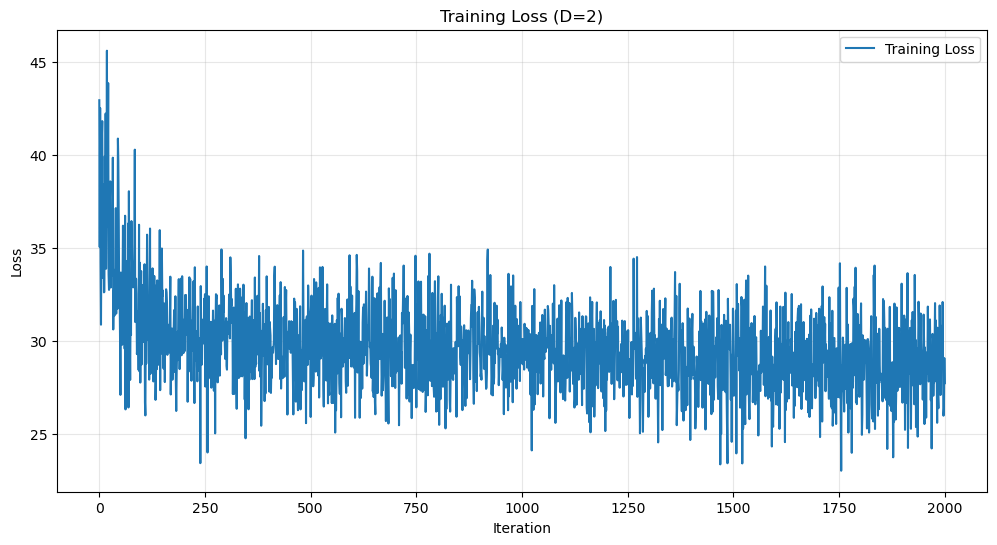

In [231]:
# -------- 1. Plot Learning Curve --------
plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Training Loss')
plt.title(f"Training Loss (D={D})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

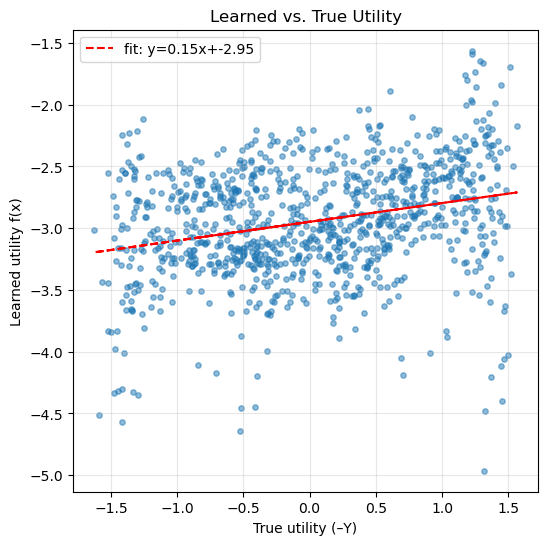

In [232]:
# ---- after training ----
import matplotlib.pyplot as plt

# 1. Sample a bunch of random interventions
N_vis = 1000
# domain = [−2,2] in each dimension (same as PCBO_SyntheticDataset)
X_vis = (torch.rand(N_vis, D) * (dataset.domain[1] - dataset.domain[0])
         + dataset.domain[0]).to(device)

# 2. Compute true utility and learned utility
with torch.no_grad():
    Y_vis = dataset.scm(X_vis)
    logf_vis, _ = prefflow.f(X_vis)
    u_true = (-Y_vis).cpu().numpy()
    u_learn = logf_vis.cpu().numpy()

# 3. Scatter
plt.figure(figsize=(6,6))
plt.scatter(u_true, u_learn, alpha=0.5, s=15)
m, b = np.polyfit(u_true, u_learn, 1)
plt.plot(u_true, m*u_true+b, 'r--', label=f'fit: y={m:.2f}x+{b:.2f}')
plt.xlabel('True utility (–Y)')
plt.ylabel('Learned utility f(x)')
plt.title('Learned vs. True Utility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

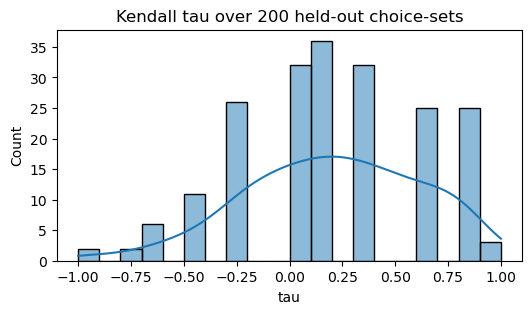

Mean tau: 0.20600000000000002


In [233]:
import seaborn as sns
from scipy.stats import kendalltau

def ranking_tau(prefflow, dataset, n_trials=200):
    taus = []
    for _ in range(n_trials):
        # sample one fresh query
        Xk, _, Yk = dataset._generate_one_query()  # now returns (k,d), idx, (k,)
        
        # true utility = –Yk
        u_true = (-Yk).cpu().numpy()
        
        # learned utility f(x)
        with torch.no_grad():
            logf, _ = prefflow.f(Xk.to(prefflow.device))  # shape (k,)
            u_learn = logf.cpu().numpy()
        
        tau, _ = kendalltau(u_true, u_learn)
        taus.append(tau)
    return np.array(taus)

taus = ranking_tau(prefflow, dataset, n_trials=200)
plt.figure(figsize=(6,3))
sns.histplot(taus, kde=True, bins=20)
plt.title(f'Kendall tau over {len(taus)} held-out choice-sets')
plt.xlabel('tau'); plt.ylabel('Count')
plt.show()
print('Mean tau:', taus.mean())

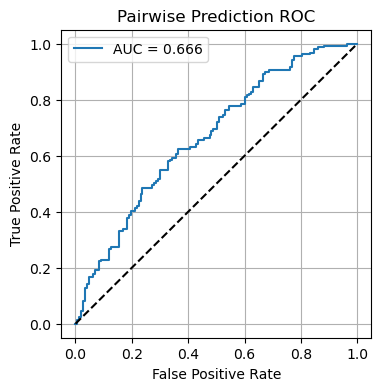

In [234]:
from sklearn.metrics import roc_curve, auc

# Build a test set of pairwise comps
probs, labels = [], []
for _ in range(300):
    # sample 2 interventions
    X2 = (torch.rand(2, D)*(dataset.domain[1]-dataset.domain[0]) + dataset.domain[0]).to(device)
    Y = dataset.scm(X2).cpu().numpy()
    true_label = 1 if Y[0]<Y[1] else 0  # “1” means index 0 wins
    # model’s probability index 0 wins:
    with torch.no_grad():
        logf, _ = prefflow.f(X2)
        p0 = torch.sigmoid((logf[0]-logf[1])/prefflow.s).cpu().item()
    probs.append(p0)
    labels.append(true_label)

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Pairwise Prediction ROC')
plt.legend(); plt.grid(True)
plt.show()

### Update Parent Posterior

In [235]:
ppost = ParentPosterior(d=2, sigma_eps=0.1, sigma_theta=1.0, prior_sparsity=0.3)
for x,y in some_points_from_dataset:
    ppost.add_datapoint(x.unsqueeze(0), y.item())
ppost.update_posterior()
print("Edge probs:", ppost.edge_posterior())

NameError: name 'some_points_from_dataset' is not defined

In [ ]:
pp = ParentPosterior(d=2)
for _ in range(3):
    x = torch.randn(1,2)
    y = torch.randn(1)
    pp.add_datapoint(x,y)
pp.update_posterior()
print("Edge probs:", pp.edge_posterior())

Edge probs: tensor([0.4285, 1.0000], dtype=torch.float64)


### Visualise DAG with posterior edge weights

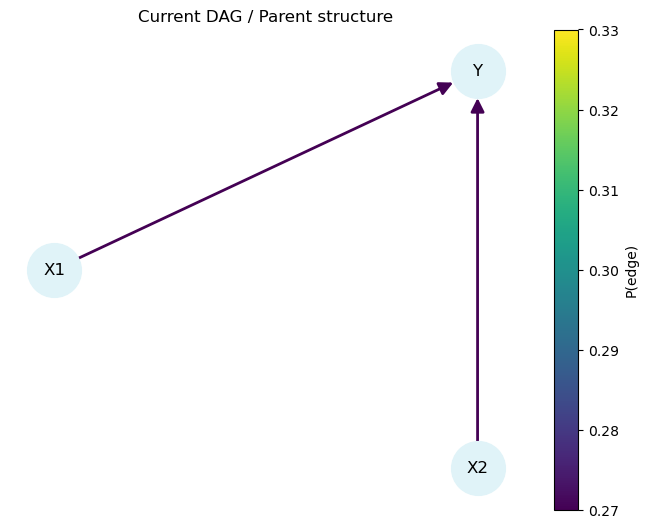

In [ ]:
adj = np.array([[0,0,1],
                [0,0,1],
                [0,0,0]])
edge_probs = np.array([[0,0,ppost.edge_posterior()[0]],
                       [0,0,ppost.edge_posterior()[1]],
                       [0,0,0]])
plot_dag(adj, names=["X1","X2","Y"], edge_probs=edge_probs)